# Forecasting model for P2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import typing
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

%load_ext autoreload
%autoreload 2

np.random.seed(42)

In [2]:
wind_dir = {'Ветер, дующий с востока': 0,
            'Ветер, дующий с востоко-северо-востока': 45/2,
            'Ветер, дующий с северо-востока': 45,
            'Ветер, дующий с северо-северо-востока': 45 + 45/2,
            'Ветер, дующий с севера': 90,
            'Ветер, дующий с северо-северо-запад': 90 + 45/2,
            'Ветер, дующий с северо-запада': 135,
            'Ветер, дующий с западо-северо-запада': 135 + 45/2,
            'Ветер, дующий с запада': 180,
            'Ветер, дующий с западо-юго-запада': 180+45/2,
            'Ветер, дующий с юго-запада': 225,
            'Ветер, дующий с юго-юго-запада': 225 + 45/2,
            'Ветер, дующий с юга': 270,
            'Ветер, дующий с юго-юго-востока': 270 + 45/2,
            'Ветер, дующий с юго-востока': 315,
            'Ветер, дующий с востоко-юго-востока': 315 + 45/2,
            'Штиль, безветрие': None,
            }

In [3]:
def prepare_features(data: pd.DataFrame) -> pd.DataFrame:
    """Features preparation for anomaly detection and clustering"""
    # textual values encoding
    data['hum_meteo'] = data.hum_meteo.fillna(method='bfill')
    data['pres_meteo'] = data.hum_meteo.fillna(method='bfill')
    data['wind_speed'] = data.hum_meteo.fillna(method='bfill')
    data['temp_meteo'] = data.temp_meteo.fillna(method='bfill')
    data['prec_amount'] = data.prec_amount.fillna(method='bfill')
    data.loc[data.prec_amount == 'Осадков нет', 'prec_amount'] = 0
    data.loc[data.prec_amount == 'Следы осадков', 'prec_amount'] = 0
    data['prec_amount'] = data.prec_amount.astype(float)

    
    # fill missing value before PCA
    data['P1'] = data.P1.interpolate()
    
    for c in data.columns:
        data[c].fillna((data[c].mean()), inplace=True)
    
    return data

In [4]:
data = pd.read_csv('../DATA/processed/dataset.csv', parse_dates=['date'])
data = data.set_index('date')
data.columns

Index(['P1', 'P2', 'pressure', 'temperature', 'humidity', 'temp_meteo',
       'pres_meteo', 'hum_meteo', 'wind_direction', 'wind_speed',
       'precipitation', 'prec_amount', 'visibility', 'dew_point_temp'],
      dtype='object')

In [5]:
sel_columns = ['P1', 'P2', 'hum_meteo', 'temp_meteo', 'pres_meteo', 'wind_speed', 'prec_amount',
               'pressure', 'temperature', 'humidity',]

In [6]:
data = data[sel_columns]
data = prepare_features(data)

In [7]:
data['day_of_week'] = data.index.dayofweek
data['weekend'] = data.day_of_week.apply(lambda d: d == 5 or d == 6).astype(int)
data['hour'] = data.index.hour
data['night'] = data.hour.apply(lambda h: 0<= h < 7).astype(int)
data['morning'] = data.hour.apply(lambda h: 7<= h < 12).astype(int)
data['day'] = data.hour.apply(lambda h: 12<= h < 17).astype(int)
data['evening'] = data.hour.apply(lambda h: 17<= h < 24).astype(int)
data['sin_day'] = np.sin(2*np.pi*data.day_of_week/7)
data['cos_day'] = np.cos(2*np.pi*data.day_of_week/7)
data['sin_hour'] = np.sin(2*np.pi*data.hour/24)
data['cos_hour'] = np.cos(2*np.pi*data.hour/24)

data.drop(columns=['day_of_week', 'hour', 'night', 'day', 'morning', 'evening'], inplace=True)

In [8]:
data = data.resample('1H').mean()

In [9]:
for c in data.columns:
    if data[c].isnull().values.any():
        print(c)

In [10]:
data.head()

,P1,P2,hum_meteo,temp_meteo,pres_meteo,wind_speed,prec_amount,pressure,temperature,humidity,weekend,sin_day,cos_day,sin_hour,cos_hour
date,,,,,,,,,,,,,,,
2019-04-01 00:00:00,5.897103,3.146379,59.000000,6.70,59.000000,59.000000,0.0,98537.248924,6.936076,55.387396,0,0.0,1.0,0.000000,1.000000
2019-04-01 01:00:00,4.495774,2.165790,59.000000,6.70,59.000000,59.000000,0.0,98592.497813,6.386736,53.921771,0,0.0,1.0,0.258819,0.965926
2019-04-01 02:00:00,4.090302,1.930446,59.000000,6.70,59.000000,59.000000,0.0,98676.193542,5.564792,56.008229,0,0.0,1.0,0.500000,0.866025
2019-04-01 03:00:00,6.187858,2.532042,60.833333,5.05,60.833333,60.833333,0.0,98767.538403,4.671840,60.999618,0,0.0,1.0,0.707107,0.707107
2019-04-01 04:00:00,3.100704,1.111403,61.000000,4.90,61.000000,61.000000,0.0,98861.067153,4.998715,60.602222,0,0.0,1.0,0.866025,0.500000


In [11]:
def pp(start, end, n):
    start_u = start.value//10**9
    end_u = end.value//10**9

    return pd.DatetimeIndex((10**9*np.random.randint(start_u, end_u, n)).view('M8[ns]'))

In [12]:
start_idx = data.index[0]
end_idx = data.index[-1] - datetime.timedelta(days=2)
num_samples = 1500

In [13]:
def generate_chunks(series, n, start, end):
    chunks = []
    for idx in pp(start, end, n):
        c = series[str(idx):str(idx+datetime.timedelta(days=2))]
        chunks.append(c)
    return chunks

In [14]:
chunks = generate_chunks(data, num_samples, start_idx, end_idx)

In [15]:
data.columns

Index(['P1', 'P2', 'hum_meteo', 'temp_meteo', 'pres_meteo', 'wind_speed',
       'prec_amount', 'pressure', 'temperature', 'humidity', 'weekend',
       'sin_day', 'cos_day', 'sin_hour', 'cos_hour'],
      dtype='object')

In [16]:
target_column = 'P2'
columns = ['P2', 'pressure', 'temperature', 'humidity']

In [17]:
def create_sample(chank, target_col, columns):
    X = dict()
    y = dict()
    d1 = chank.iloc[:24]
    d2 = chank.iloc[24:]
    for i in range(24):
        for c in columns:
            X[f'{c}_lag_{i}'] = d1[target_col][-(i+1)]
        y[f'{target_col}_forec_{i}'] = d2[target_col][i]
    return X, y
    

In [18]:
def prepare_data_from_chunks(chunks, target, col):
    df = pd.DataFrame(index=range(len(chunks)))
    for i in range(len(chunks)):
        x, y = create_sample(chunks[i], target, col)
        #print(x, y)
        for key, value in x.items():
            df.loc[i, key] = value
        for key, value in y.items():
            df.loc[i, key] = value
    return df

In [19]:
df = prepare_data_from_chunks(chunks, target_column, columns)

In [20]:
df.head()

,P2_lag_0,pressure_lag_0,temperature_lag_0,humidity_lag_0,P2_lag_1,pressure_lag_1,temperature_lag_1,humidity_lag_1,P2_lag_2,pressure_lag_2,...,P2_forec_14,P2_forec_15,P2_forec_16,P2_forec_17,P2_forec_18,P2_forec_19,P2_forec_20,P2_forec_21,P2_forec_22,P2_forec_23
0,27.849996,27.849996,27.849996,27.849996,26.519627,26.519627,26.519627,26.519627,25.431341,25.431341,...,11.603593,10.241881,11.698933,12.048403,12.297604,12.290739,12.874482,13.834333,15.411800,18.546691
1,3.551040,3.551040,3.551040,3.551040,3.723534,3.723534,3.723534,3.723534,3.810514,3.810514,...,4.390089,3.472560,2.862591,2.812419,3.414300,4.228670,3.797086,2.892590,2.845753,2.933176
2,20.094516,20.094516,20.094516,20.094516,21.032177,21.032177,21.032177,21.032177,22.313508,22.313508,...,6.036762,6.104033,5.527766,5.065202,4.676086,4.680969,4.742652,4.661168,4.730111,4.371600
3,1.096065,1.096065,1.096065,1.096065,1.016543,1.016543,1.016543,1.016543,1.114512,1.114512,...,8.248469,8.248469,8.248469,8.248469,8.248469,8.248469,8.248469,8.248469,8.248469,8.248469
4,2.482056,2.482056,2.482056,2.482056,2.565897,2.565897,2.565897,2.565897,2.732261,2.732261,...,7.568206,8.551766,10.107980,11.109161,11.226499,11.529410,11.659414,12.042151,12.056312,12.578175


In [21]:
x_columns = [i for i in df.columns if 'P2_forec_' not in i]
y_columns = [i for i in df.columns if 'P2_forec_' in i]

In [22]:
X, y = df[x_columns], df[y_columns]

In [23]:
for c in X.columns:
    if X[c].isnull().values.any():
        print(c)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
X_train.head()

,P2_lag_0,pressure_lag_0,temperature_lag_0,humidity_lag_0,P2_lag_1,pressure_lag_1,temperature_lag_1,humidity_lag_1,P2_lag_2,pressure_lag_2,...,temperature_lag_21,humidity_lag_21,P2_lag_22,pressure_lag_22,temperature_lag_22,humidity_lag_22,P2_lag_23,pressure_lag_23,temperature_lag_23,humidity_lag_23
485,3.260275,3.260275,3.260275,3.260275,2.807510,2.807510,2.807510,2.807510,2.735030,2.735030,...,5.518340,5.518340,5.663728,5.663728,5.663728,5.663728,6.405033,6.405033,6.405033,6.405033
527,1.304487,1.304487,1.304487,1.304487,2.834842,2.834842,2.834842,2.834842,4.037597,4.037597,...,3.641091,3.641091,3.545353,3.545353,3.545353,3.545353,3.393490,3.393490,3.393490,3.393490
199,22.241815,22.241815,22.241815,22.241815,27.031099,27.031099,27.031099,27.031099,28.032382,28.032382,...,8.919029,8.919029,9.183046,9.183046,9.183046,9.183046,10.100596,10.100596,10.100596,10.100596
889,17.509771,17.509771,17.509771,17.509771,16.430633,16.430633,16.430633,16.430633,15.777844,15.777844,...,8.272669,8.272669,8.547772,8.547772,8.547772,8.547772,9.401364,9.401364,9.401364,9.401364
844,22.724669,22.724669,22.724669,22.724669,23.668020,23.668020,23.668020,23.668020,22.438577,22.438577,...,14.261206,14.261206,15.268370,15.268370,15.268370,15.268370,15.370140,15.370140,15.370140,15.370140


In [26]:
#scaler = StandardScaler()
#col = X_train.columns
#X_train[col] = scaler.fit_transform(X_train[col])
#X_test[col] = scaler.transform(X_test[col])

In [27]:
X_train.head()

,P2_lag_0,pressure_lag_0,temperature_lag_0,humidity_lag_0,P2_lag_1,pressure_lag_1,temperature_lag_1,humidity_lag_1,P2_lag_2,pressure_lag_2,...,temperature_lag_21,humidity_lag_21,P2_lag_22,pressure_lag_22,temperature_lag_22,humidity_lag_22,P2_lag_23,pressure_lag_23,temperature_lag_23,humidity_lag_23
485,3.260275,3.260275,3.260275,3.260275,2.807510,2.807510,2.807510,2.807510,2.735030,2.735030,...,5.518340,5.518340,5.663728,5.663728,5.663728,5.663728,6.405033,6.405033,6.405033,6.405033
527,1.304487,1.304487,1.304487,1.304487,2.834842,2.834842,2.834842,2.834842,4.037597,4.037597,...,3.641091,3.641091,3.545353,3.545353,3.545353,3.545353,3.393490,3.393490,3.393490,3.393490
199,22.241815,22.241815,22.241815,22.241815,27.031099,27.031099,27.031099,27.031099,28.032382,28.032382,...,8.919029,8.919029,9.183046,9.183046,9.183046,9.183046,10.100596,10.100596,10.100596,10.100596
889,17.509771,17.509771,17.509771,17.509771,16.430633,16.430633,16.430633,16.430633,15.777844,15.777844,...,8.272669,8.272669,8.547772,8.547772,8.547772,8.547772,9.401364,9.401364,9.401364,9.401364
844,22.724669,22.724669,22.724669,22.724669,23.668020,23.668020,23.668020,23.668020,22.438577,22.438577,...,14.261206,14.261206,15.268370,15.268370,15.268370,15.268370,15.370140,15.370140,15.370140,15.370140


In [28]:
def get_mae(models, X_test, y_test, y_columns):
    scores = []
    for i in range(len(y_columns)):
        local_model = models[i]
        prediction = local_model.predict(X_test)
        mae = mean_absolute_error(y_test[y_columns[i]], prediction)
        scores.append(mae)
    return scores

In [29]:
def train_models(model, x_train, y_train, y_columns):
    models = []
    for i in range(len(y_columns)):
        local_model = clone(model)
        local_model.fit(x_train, y_train[y_columns[i]])
        models.append(local_model)
    return models

In [30]:
mod = Lasso(alpha=0.2, max_iter=2000)
models  = train_models(mod, X_train, y_train, y_columns)

In [31]:
mae = get_mae(models, X_test, y_test, y_columns)

In [32]:
mae, np.mean(mae)

([0.8143717996219665,
  1.5247700005734188,
  2.045730990749463,
  2.5290684424083225,
  2.9552447985310493,
  3.1937968577356495,
  3.4435963639854013,
  3.7060475756592233,
  3.8740323784520116,
  3.9826490028472077,
  4.0251039115080625,
  4.125845874381198,
  4.177685990612305,
  4.351073475471908,
  4.333022950148783,
  4.27588766691372,
  4.231643254078302,
  4.232131727848493,
  4.295862695321744,
  4.358379583586071,
  4.2730150037836525,
  4.2559843456181765,
  4.324350386046556,
  4.427714770035683],
 3.656542076913265)

In [33]:
mae, np.mean(mae)

([0.8143717996219665,
  1.5247700005734188,
  2.045730990749463,
  2.5290684424083225,
  2.9552447985310493,
  3.1937968577356495,
  3.4435963639854013,
  3.7060475756592233,
  3.8740323784520116,
  3.9826490028472077,
  4.0251039115080625,
  4.125845874381198,
  4.177685990612305,
  4.351073475471908,
  4.333022950148783,
  4.27588766691372,
  4.231643254078302,
  4.232131727848493,
  4.295862695321744,
  4.358379583586071,
  4.2730150037836525,
  4.2559843456181765,
  4.324350386046556,
  4.427714770035683],
 3.656542076913265)

In [34]:
def predict_on_chank(chank, models, columns, target_col='P1'):
    d1 = chank.iloc[:24]
    d2 = chank.iloc[24:]
    X = pd.DataFrame(index=range(1))
    for i in range(24):
        for c in columns:
            X[f'{c}_lag_{i}'] = d1[target_col][-(i+1)]
    y = d2[target_col]

    pred = []
    for i in range(len(models)):
        mod = models[i]
        pred.append(mod.predict(X)[0])
    return y,pred 

In [38]:
y_chank, pred = predict_on_chank(chunks[45], models, columns, target_col='P2')

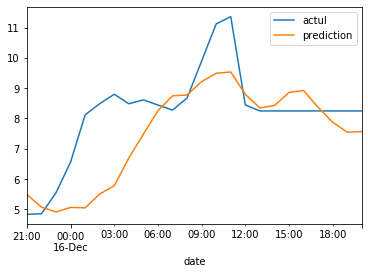

In [39]:
result = pd.DataFrame({'actul': y_chank})
result['prediction'] = pred
result.plot()

In [37]:
def print_coef(model):
    coef = pd.DataFrame(index=range(len(x_columns)))
    coef['featurs'] = x_columns
    coef['importance'] = model.coef_
    print(coef)